# Import libraries

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix

import cv2
import os

import numpy as np
import pandas as pd

In [32]:
print(tf.__version__)

2.19.0


In [33]:
print("data\yes//2491975_1119775.jpg")

data\yes//2491975_1119775.jpg


# Train-Test Split
80% - 20%

momentan insgesamt je 300 Bilder --> dh. 240 für Training, 60 Testing

# Loading data

In [34]:
labels = ['no', 'yes'] # yes: green electro parking spot
# 'no' = 0, 'yes' = 1
img_size = 224  # Zielgrösse Bilder           

def get_data(data_dir):
    X = []  # Bilddaten
    y = []  # zugehörigen Labels 0 oder 1 

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]    # Bild einlesen, in RGB umwandeln 
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Bild auf einheitliche Grösse skalieren
                X.append(resized_arr)
                y.append(class_num)
            except Exception as e:
                print(f"Fehler bei {img}: {e}")

    return np.array(X), np.array(y)

In [35]:
# alle Daten laden 
x_data, y_data = get_data('data')   # X=Bild, y=Label, 0 für no, 1 für yes
print("Gesamtdaten:", x_data.shape, y_data.shape)

Gesamtdaten: (600, 224, 224, 3) (600,)


# Data Preprocessing, Data Augmentation and Visualization 

In [36]:
# Bilder drehen und spiegel aus 1 Orginalbild -> 12 Testbilder 
def rotate_and_flip_images(x, y):
    x_aug, y_aug = [], []
    for img, label in zip(x, y):
        for k in range(4):  # 0°, 90°, 180°, 270°
            rotated = np.rot90(img, k=k)
            x_aug.append(rotated); y_aug.append(label)
            x_aug.append(np.fliplr(rotated)); y_aug.append(label)  # Horizontal Flip
            #x_aug.append(np.flipud(rotated)); y_aug.append(label)  # Vertical Flip
    return np.array(x_aug), np.array(y_aug)

# Define the Model

In [37]:
def create_model():
    model = Sequential()

    # 1. Convolutional Layer
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(224, 224, 3)))
    model.add(BatchNormalization())  # Normalize after convolution
    model.add(MaxPool2D())

    # 2. Convolutional Layer
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())  # Normalize after convolution
    model.add(MaxPool2D())

    # 3. Convolutional Layer + Dropout to prevent overfitting
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())  # Normalize after convolution
    model.add(MaxPool2D())
    model.add(Dropout(0.4))

    # Global Average Pooling instead of Flatten
    model.add(GlobalAveragePooling2D())  # Reduces the size of the output (fewer parameters)

    # Dense Layer
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))  # Dropout to prevent overfitting

    # Output Layer (Sigmoid for binary classification)
    model.add(Dense(1, activation="sigmoid"))

    # Model Summary
    model.summary()

    # Optimizer and Callbacks
    optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate for better convergence

    # Compile the Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [38]:

def train_model(model, x_train, y_train, x_val, y_val, batch_size=16, epochs=10):
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

    # Train Model
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stop, lr_scheduler],
        verbose=1
    )
    
    return history

# K-folds Schleife


Fold 1 Datenübersicht:


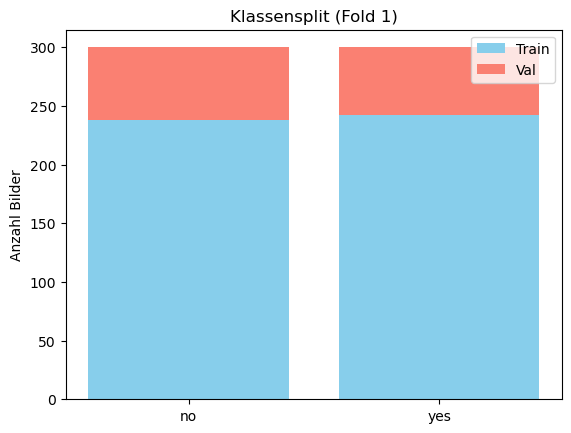

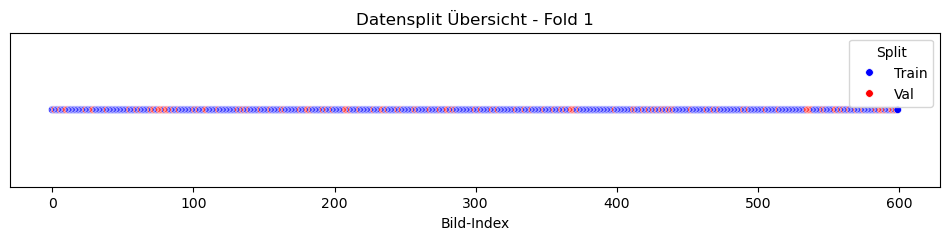

Train shape: (480, 224, 224, 3) (480,)
Val shape: (120, 224, 224, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480
Nach Augmentation: (3840, 224, 224, 3) (3840,)


/home/nachbaisabel@edu.local/miniconda3/envs/green_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 161s 664ms/step - accuracy: 0.6288 - loss: 0.6309 - val_accuracy: 0.5333 - val_loss: 0.6742 - learning_rate: 1.0000e-04
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 159s 664ms/step - accuracy: 0.7302 - loss: 0.5287 - val_accuracy: 0.5333 - val_loss: 0.7064 - learning_rate: 1.0000e-04
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 159s 661ms/step - accuracy: 0.7730 - loss: 0.4761 - val_accuracy: 0.6250 - val_loss: 0.5723 - learning_rate: 1.0000e-04
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 159s 661ms/step - accuracy: 0.8252 - loss: 0.4060 - val_accuracy: 0.8833 - val_loss: 0.3323 - learning_rate: 1.0000e-04
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 158s 660ms/step - accuracy: 0.8346 - loss: 0.3806 - val_accuracy: 0.8500 - val_loss: 0.3314 - learning_rate: 1.0000e-04
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 158s 657ms/step - accuracy: 0.8651 - loss: 0.3266 - val_accuracy: 0.7917 - val_loss: 0.4032 - learning_rate: 1.0000e-04
Epoch 7/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Normalisieren --> Pixelwerte von 0-255 enspricht 0-1
x_data = x_data / 255.0

# Labels als float32 für binary_crossentropy
y_data = y_data.astype('float32')

# K-Fold vorbereiten - Cross Validation 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, val_index in kf.split(x_data):
    print(f'\n====================')
    print(f'Fold {fold_no} Datenübersicht:')

    # Aufteilen in Training / Validation
    x_train, x_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]

    # Ursprüngliche Labels (ohne Augmentation!) → Verteilung im Original-Split
    train_labels = y_data[train_index].astype(int)
    val_labels = y_data[val_index].astype(int)

    # Anzahl pro Klasse
    train_no = np.sum(train_labels == 0)
    train_yes = np.sum(train_labels == 1)
    val_no = np.sum(val_labels == 0)
    val_yes = np.sum(val_labels == 1)

    labels_classes = ['no', 'yes']
    train_counts = [train_no, train_yes]
    val_counts = [val_no, val_yes]

    x = np.arange(len(labels_classes))

    fig, ax = plt.subplots()
    ax.bar(x, train_counts, label='Train', color='skyblue')
    ax.bar(x, val_counts, bottom=train_counts, label='Val', color='salmon')

    ax.set_ylabel('Anzahl Bilder')
    ax.set_title(f'Klassensplit (Fold {fold_no})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels_classes)
    ax.legend()

    plt.show()
   
    
    # Visualisieren, welche Bilder train / val sind
    split_labels = []
    for idx in range(len(x_data)):
        if idx in train_index:
            split_labels.append('Train')
        elif idx in val_index:
            split_labels.append('Val')
        else:
            split_labels.append('Unknown')

    df = pd.DataFrame({'Index': range(len(x_data)), 'Split': split_labels})

    # Plot
    plt.figure(figsize=(12, 2))
    sns.scatterplot(data=df, x='Index', y=[1]*len(df), hue='Split', palette={'Train': 'blue', 'Val': 'red'}, legend='full', s=30)
    plt.title(f'Datensplit Übersicht - Fold {fold_no}')
    plt.yticks([])
    plt.xlabel('Bild-Index')
    plt.show()


    # Shape vor Augmentation 
    print("Train shape:", x_train.shape, y_train.shape)
    print("Val shape:", x_val.shape, y_val.shape)

    # Beispiel-Labels anzeigen
    print("\nLabel-Beispiel1:", int(y_train[0]), "→", labels[int(y_train[0])])
    print("Label-Beispiel2:", int(y_train[-1]), "→", labels[int(y_train[-1])])

    # Anzahl Daten
    print("\nLänge Trainingsdaten:", len(x_train))
    print("Länge Labels:", len(y_train))

    # Data Augmentation auf Trainingsdaten
    x_train, y_train = rotate_and_flip_images(x_train, y_train)
    print("Nach Augmentation:", x_train.shape, y_train.shape)
    
    # Model erzeugen
    model = create_model()

    # ModelCheckpoint Callback → speichert bestes Modell pro Fold
    checkpoint = ModelCheckpoint(f'model_fold_{fold_no}.h5', monitor='val_accuracy', save_best_only=True)

    # 3840 Trainingsbilder / 16 batch_size = 240 steps
    history = train_model(model, x_train, y_train, x_val, y_val, batch_size=16, epochs=30)


    # Bilder der Resultate 

    # Vorhersagen
    predictions = model.predict(x_val)
    predictions = (predictions > 0.5).astype("int32").reshape(-1)
    y_val_int = y_val.astype(int)

    # Classification Report
    print(classification_report(y_val_int, predictions, target_names=['kein E-Parkplatz (0)', 'grüner E-Parkplatz (1)']))

    # Confusion Matrix
    cm = confusion_matrix(y_val_int, predictions)
    labels_cm = ['kein E-Parkplatz', 'grüner E-Parkplatz']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels_cm,
                yticklabels=labels_cm)
    plt.xlabel('Vorhergesagte Klasse')
    plt.ylabel('Tatsächliche Klasse')
    plt.title(f'Fold {fold_no}: Confusion Matrix')
    plt.show()

    # Loss & Accuracy Plot
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Trainingsgenauigkeit')
    plt.plot(epochs_range, val_acc, label='Validierungsgenauigkeit')
    plt.legend(loc='lower right')
    plt.title('Trainings- und Validierungsgenauigkeit')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Trainingsverlust')
    plt.plot(epochs_range, val_loss, label='Validierungsverlust')
    plt.legend(loc='upper right')
    plt.title('Trainings- und Validierungsverlust')

    plt.show()

    # fold_no am Ende des Loops hochzählen
    fold_no += 1



# Evaluating results